<a href="https://colab.research.google.com/github/lejimmy/ieee-cis-fraud-detection/blob/master/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection

Our Tasks

- Explore and visualize the dataset
- Decide which features are important
- Perform Machine Learning
- Test the model on the testing set

## Load the data

In [2]:
!pip install -q kaggle # install kaggle
from google.colab import files 
files.upload() # upload your Kaggle API key

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lejimmy","key":"ea08e88ddea7f24d941cf4a139996161"}'}

In [0]:
!mkdir ~/.kaggle # make directory named kaggle
!cp kaggle.json ~/.kaggle/ # copy Kaggle json to folder
!chmod 600 ~/.kaggle/kaggle.json # change permissions to read/write

In [0]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
import random

In [5]:
!kaggle competitions download -c ieee-fraud-detection # download dataset

 70% 37.0M/52.5M [00:00<00:00, 66.4MB/s]
100% 52.5M/52.5M [00:00<00:00, 133MB/s] 
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 100MB/s]
 87% 41.0M/47.3M [00:00<00:00, 73.9MB/s]
100% 47.3M/47.3M [00:00<00:00, 80.6MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 202MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 164MB/s]


In [6]:
# unzip dataset
!unzip train_transaction.csv.zip
!unzip test_transaction.csv.zip
!unzip train_identity.csv.zip
!unzip test_identity.csv.zip 

Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   
Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    
Archive:  train_identity.csv.zip
  inflating: train_identity.csv      
Archive:  test_identity.csv.zip
  inflating: test_identity.csv       


In [0]:
df = pd.read_csv('train_transaction.csv', low_memory = False) # read into dataframe

## Preview the data

In [8]:
df.head() # preview dataset

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df['isFraud'].value_counts() # count number of fraudulent transactions

0    569877
1     20663
Name: isFraud, dtype: int64

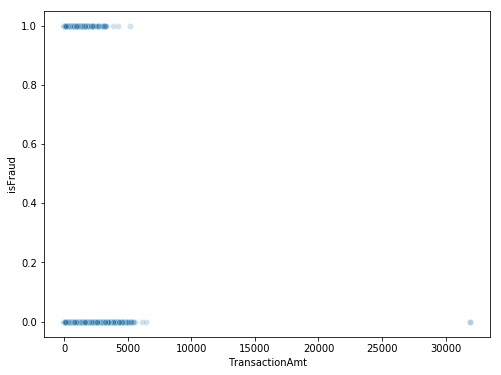

In [10]:
# visualize fraud vs transactions amounts
plt.figure(figsize=(8,6))
ax = sns.scatterplot(data = df, x = 'TransactionAmt', y = 'isFraud', alpha = 0.2)

In [11]:
df.describe() # summary of numerical columns

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,...,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,...,0.045507,0.052002,0.251761,0.283140,0.264208,1.000007,139.748713,408.682375,230.413180,10.995986,118.195658,4.202175,39.173910,21.351473,43.319174,26.806977,109.818544,247.606741,162.153398,18.372476,42.073133,28.326584,6.220289,13.103775,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,...,0.289573,0.318310,0.481889,0.623608,0.528238,0.002603,2348.849634,4391.992977,3021.924247,116.254277,352.983093,102.374938,172.128339,95.902970,173.619028,116.853222,2270.033202,3980.042828,2793.343636,332.304848,473.499307,382.053171,56.022561,106.739813,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.

From the previews, we can see we have a lot of missing values.  Let's explore this further.

In [0]:
# percentage of missing data for each column
na_ratio = df.isna().mean().sort_values(ascending = False)

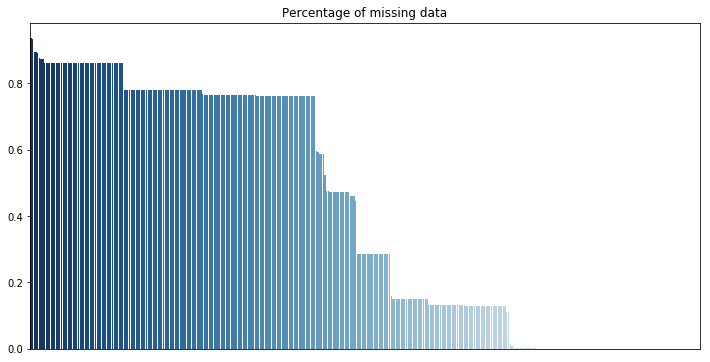

In [13]:
# plot percentage of missing values
plt.figure(figsize=(12,6))
ax = sns.barplot(na_ratio.index, na_ratio.values, palette='Blues_r')
ax.set(title = 'Percentage of missing data', xticks=[], xticklabels=[]);

## Clean the data

There looks like a steep cliff at around ~80% missing data to ~50% missing data.

We will drop the columns with more than 50% missing data and impute the remainder.

In [0]:
criteria = df.isna().mean() < .50 # list of columns with less than 50% missing data

In [15]:
df[criteria.index[criteria]].head() # preview new columns

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D10,D11,D15,M1,M2,M3,M4,M6,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,13.0,13.0,0.0,T,T,T,M2,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,M0,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,315.0,315.0,T,T,T,M0,F,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,84.0,NaN,111.0,NaN,NaN,NaN,M0,F,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_new = df[criteria.index[criteria]] # save to new df

# separate features and labels
df_labels = df_new['isFraud'].copy()
df_train = df_new.drop('isFraud', axis = 1)

## Prepare for ML

In [0]:
# split quantitative and qualitative columns
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

df_num = df_train.drop(qualitative, axis = 1) # separate the numerical features

df_cat = df_train[qualitative] # separate the categorical features

In [24]:
# preview categorical columns
df_cat.head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M6
0,W,discover,credit,NaN,T,T,T,M2,T
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,M0,T
2,W,visa,debit,outlook.com,T,T,T,M0,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,M0,F
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN


In [25]:
# preview numerical data
df_num.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,84.0,NaN,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')), # fill in missing values with median
        ('std_scaler', StandardScaler()), # scale features
])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy = 'most_frequent')), # fill missing values with most frequent
        ('one_hot', OneHotEncoder()) # encode to numbers
])

In [0]:
from sklearn.compose import ColumnTransformer

num_attribs = list(df_num) # list of numerical features
cat_attribs = list(df_cat) # list of categorical features

full_pipeline = ColumnTransformer([
          ('num', num_pipeline, num_attribs), # call numerical transformation
          ('cat', cat_pipeline, cat_attribs) # call categorical transformation
])

df_prepared = full_pipeline.fit_transform(df_train) # fit and transform pipeline

# Select and train a model

Let's start with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn's `SGDClassifer` class:

In [32]:
from sklearn.linear_model import SGDClassifier

# model constructor
sgd_clf = SGDClassifier()

# train model given transaction details and labels
sgd_clf.fit(df_prepared, df_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

# Performance Measures

## Measuring accuracy using cross-validation

We can use the cross_val_score() function to evaluate the performance of our SGDClassifier model using K-fold cross-validation with 3 folds. The function will split the training set into K-folds (3 in this case), make predictions and evaluate them on each fold using the model trained on the remaining folds.

In [36]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, df_prepared, df_labels, cv = 3, scoring = 'accuracy')

array([0.96137609, 0.96793957, 0.96328602])

Looks like we scored over 96% on each fold!

Let's look at the confusion matrix to evaluate the performance in more detail.

First, we will get predictions with the `cross_val_predict()` function across 3 folds just like the previous `cross_val_score()` function.

In [0]:
from sklearn.model_selection import cross_val_predict

df_labels_pred = cross_val_predict(sgd_clf, df_prepared, df_labels, cv = 3)

Now that we have 3 predictions, we can call the `confusion_matrix()` function.

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df_labels, df_labels_pred)

array([[567724,   2153],
       [ 18688,   1975]])

The first row represents an actual class while each column represents a predicted class.

## Precision and recall

Precision is the accuracy of the positive predictions. Recall is the ratio of positive instances that are correctly detected.

To compute these classifier metrics, we can use Scikit-Learn's `precision_score` and `recall_score`.

In [39]:
from sklearn.metrics import precision_score, recall_score

precision_score(df_labels, df_labels_pred)

0.4784399224806202

In [40]:
recall_score(df_labels, df_labels_pred)

0.09558147413250738

So what does this mean?  When the model claims a transaction is fraud, it is correct 72% of the time.

However, it is only able to detect 10% of the total fraud cases.

A more convenient metric is called the F1 score which combines both precision and recall.  The F1 score is more sensitive to low values so both precision and recall must be high to achieve a high F1 score.

In [41]:
from sklearn.metrics import f1_score

f1_score(df_labels, df_labels_pred)

0.159332015650841

In [0]:
df_labels_scores = cross_val_predict(sgd_clf, df_prepared, df_labels, cv = 3, method = 'decision_function')

In [0]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(df_labels, df_labels_scores)

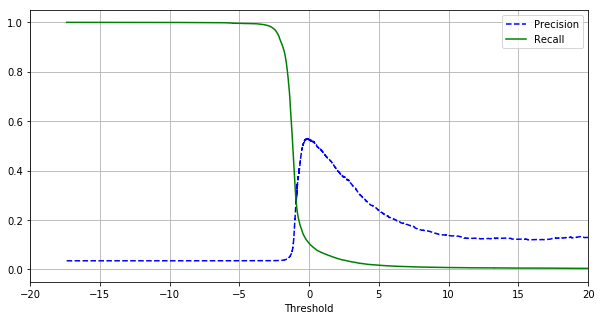

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    
    plt.legend()
    plt.xlabel('Threshold')
    plt.grid(True)

plt.figure(figsize = [10,5])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim(-20, 20)
plt.show()

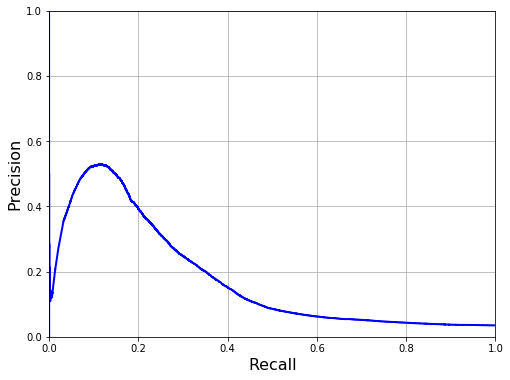

In [46]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## The ROC Curve

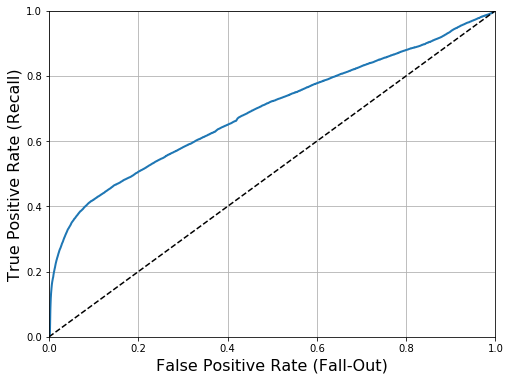

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df_labels, df_labels_scores)

def plot_roc_curve(fpr, tpr, label = 'None'):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])                                    
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
  plt.grid(True)                                           

plt.figure(figsize=(8, 6))                        
plot_roc_curve(fpr, tpr)
plt.show()

In [48]:
from sklearn.metrics import roc_auc_score

# auc score based on our training set and our scores
roc_auc_score(df_labels, df_labels_scores)

0.6913582855497521

# Evaluate another model

In [0]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(warm_start = True, n_estimators = 100)

df_probas_forest = cross_val_predict(forest_clf, df_prepared, df_labels, cv = 3, method = 'predict_proba')

In [0]:
df_scores_forest = df_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(df_labels, df_scores_forest)

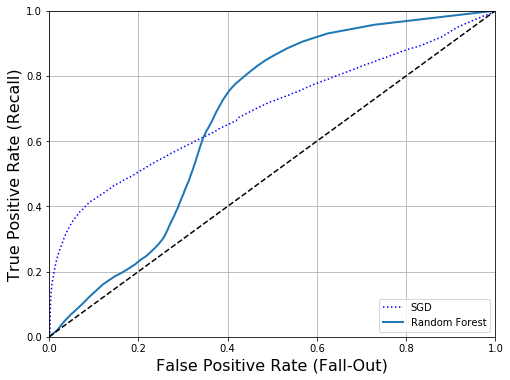

In [54]:
plt.figure(figsize = [8, 6])
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, label = 'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

In [55]:
roc_auc_score(df_labels, df_scores_forest)

0.6736387799675485

In [0]:
df_labels_pred_forest = cross_val_predict(forest_clf, df_prepared, df_labels, cv = 3)

In [62]:
precision_score(df_labels, df_labels_pred_forest)

0.05399218925161768

In [63]:
recall_score(df_labels, df_labels_pred_forest)

0.5011372985529691

In [61]:
from google.colab import files
np.savetxt('df_prepared.csv', df_prepared, delimiter=',')

MessageError: ignored